In [1]:
#!/usr/bin/env python

# process_conditions_WBGT_monthmax.ipynb

'''
    File name: process_conditions_WBGT_monthmax.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.30.2024
    Date last modified: 04.30.2024

    ############################################################## 
    Purpose:

    1) This program reads monthly CONUS404 data for WBGT and all of its dependent variable
    2) It calculates the monthly maximum of WBTG at each grid cell
    3) And derives the state of all dependent variables at the same time

    4) The final matrix will be stored for later processing

'''

In [7]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec

### User imput section

In [8]:
conus404_ctr_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/'
time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
conus404_pgw_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/'
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2011, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)
era5_dir = '/glade/campaign/mmm/c3we/ESTCP/ERA5/WBGT/'
time_era5 = pd.date_range(datetime.datetime(1950, 1, 1, 0), 
                              end=datetime.datetime(2019, 12, 31, 23), freq='h')

variables = ['GWBT','T2','Q2','PSFC','U10','V10','LWDNB','SWDNB','LWUPB','SWUPB']

savedir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/WBGT_monmax_variables/'

year = 2020 #int(sys.argv[1]) #2000
simulation = 'ctr' #str(sys.argv[2]) # 'ctr'

if simulation == 'ctr':
    conus_data_dir = conus404_ctr_dir
    time = time_c404_ctr
else:
    conus_data_dir = conus404_pgw_dir
    time = time_c404_pgw

# Read CONUS404 CTR OR PGW WBGT DATA

In [9]:
# read CONUS404 coordinates
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

In [10]:
c_ctr_years = np.unique(time_c404_ctr.year)

m,n = lon_conus.shape
I,J = np.ogrid[:m,:n]

# for yy in range(len(c_ctr_years)):
for mm in range(12):
    savefile = savedir + str(year) + str(mm+1).zfill(2) +'_WBGT_monmax_variables_'+simulation+'.npz'
    if os.path.isfile(savefile+'*') == False:
        print(simulation+' '+str(year)+'-'+str(mm+1).zfill(2))
        time_month = time[(time.year == year) & (time.month == mm+1)]
        conus_ctr = np.zeros((lon_conus.shape[0], lon_conus.shape[1], len(variables))); conus_ctr[:] = np.nan
        timestamp_max = np.empty((lon_conus.shape[0], lon_conus.shape[1]), dtype='datetime64[s]')
        for va in tqdm(range(len(variables)-1)):
            file = conus_data_dir + variables[va] +'/' + variables[va] + '_'+str(year)+str(mm+1).zfill(2)+'_CONUS404.nc'
            ncid=Dataset(file, mode='r')
            if variables[va] == 'GWBT':
                if simulation == 'ctr':
                    wbgt = np.squeeze(ncid.variables['GWBT'][:])
                else:
                    wbgt = np.squeeze(ncid.variables['__xarray_dataarray_variable__'][:])
                time_max = np.argmax(wbgt, axis=0)
                variable = np.copy(wbgt)
            else:
                variable = np.squeeze(ncid.variables[variables[va]][:])
            ncid.close()

            conus_ctr[:,:,va] = variable[time_max, I,J]

        timestamp_max[:,:] = np.reshape(time_month[time_max.flatten()], time_max.shape)
        stop()
        np.savez(savefile,
                 conus_ctr = conus_ctr,
                 timestamp_max = timestamp_max,
                 lon_conus = lon_conus,
                 lat_conus = lat_conus,
                 variables = variables
                )

ctr 2020-01


100%|██████████| 9/9 [05:02<00:00, 33.65s/it] 


> /glade/derecho/scratch/prein/tmp/ipykernel_57067/3241725159.py(32)<module>()
     30         timestamp_max[:,:] = np.reshape(time_month[time_max.flatten()], time_max.shape)
     31         stop()
---> 32         np.savez(savefile,
     33                  conus_ctr = conus_ctr,
     34                  timestamp_max = timestamp_max,



ipdb>  exit


In [16]:
conus_ctr[:,:,0] is np.max(wbgt, axis=0)

False

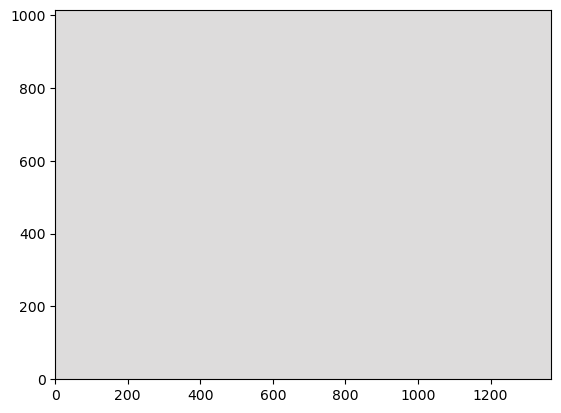

In [18]:
plt.pcolormesh(np.max(wbgt, axis=0)-conus_ctr[:,:,0], vmin=-1, vmax = 1, cmap='coolwarm')

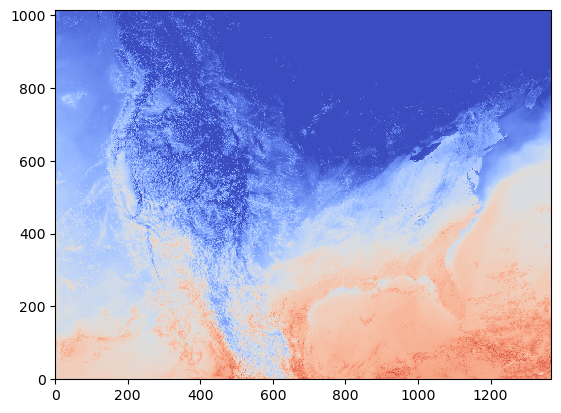

In [17]:
plt.pcolormesh(conus_ctr[:,:,0], vmin=280, vmax = 310, cmap='coolwarm')